# Create Adjacency Matrices
We create a series of adjacency matrices in which the nodes are the different ingredients found in the Recipes1M+ Database. We generate 3 different ingredient lists:
1. Full ingredients found in the Recipes 1M+ database
2. First words of ingredients in the Recipes 1M+ database
3. Full ingredients in the Recipes 1M+ database that can be cross-referenced with ingredients in the USDA nutrition facts database

We then use each of these ingredient lists to create a variety of different adjacency matrices which we subsequently use for exploration, processing, graph filtering, ingredient suggestion, ingredient replacement, and more!

## Part 1: Load data

In [39]:
%matplotlib inline
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
import itertools
from scipy.spatial.distance import pdist, squareform
from graphProcessingFunctions import epsilon_similarity_graph

In [6]:
#Load Recipes 1M+ Database
with open('../data/recipes_with_nutritional_info_fixed_qty.json') as json_file:
    data = json.load(json_file)
df = pd.DataFrame(data)
df.head()

,fsa_lights_per100g,id,ingredients,instructions,nutr_per_ingredient,nutr_values_per100g,partition,quantity,title,unit,url,weight_per_ingr,check
0,"{'fat': 'green', 'salt': 'green', 'saturates':...",000095fc1d,"[{'text': 'yogurt, greek, plain, nonfat'}, {'t...",[{'text': 'Layer all ingredients in a serving ...,"[{'fat': 0.8845044000000001, 'nrg': 133.80964,...","{'energy': 81.12946131894766, 'fat': 2.1401392...",train,"[{'text': '8'}, {'text': '1'}, {'text': '1/4'}]",Yogurt Parfaits,"[{'text': 'ounce'}, {'text': 'cup'}, {'text': ...",http://tastykitchen.com/recipes/breakfastbrunc...,"[226.796, 152.0, 30.5]",NaN
1,"{'fat': 'red', 'salt': 'orange', 'saturates': ...",00051d5b9d,"[{'text': 'sugars, granulated'}, {'text': 'oil...",[{'text': 'Cream sugar and butter together til...,"[{'fat': 0.0, 'nrg': 384.0, 'pro': 0.0, 'sat':...","{'energy': 477.09640393594606, 'fat': 23.41248...",val,"[{'text': '1/2'}, {'text': '3/4'}, {'text': '1...","Salt Free, Low Cholesterol Sugar Cookies Recipe","[{'text': 'cup'}, {'text': 'cup'}, {'text': 'c...",http://cookeatshare.com/recipes/salt-free-low-...,"[100.80000000000001, 168.0, 21.25, 5.166666666...",NaN
2,"{'fat': 'orange', 'salt': 'orange', 'saturates...",00059b093b,"[{'text': 'chicken, broilers or fryers, wing, ...","[{'text': 'Preheat oven to 400 degrees F.'}, {...","[{'fat': 174.859716, 'nrg': 2599.0821599999995...","{'energy': 208.05898280960727, 'fat': 14.29704...",train,"[{'text': '3'}, {'text': '1'}, {'text': '1/2'}...",Honey Sriracha Chicken Wings,"[{'text': 'pound'}, {'text': 'teaspoon'}, {'te...",http://tastykitchen.com/recipes/main-courses/h...,"[1360.7759999999998, 6.0, 1.15, 13.5, 42.59999...",NaN
3,"{'fat': 'orange', 'salt': 'orange', 'saturates...",0005fc89f7,"[{'text': 'crustaceans, shrimp, raw (not previ...","[{'text': 'In a large bowl, toss the shrimp, g...","[{'fat': 4.6266384, 'nrg': 771.1064, 'pro': 18...","{'energy': 194.7525956849092, 'fat': 15.980767...",train,"[{'text': '2'}, {'text': '3/4'}, {'text': '1 1...",Shrimp and Caper Salad,"[{'text': 'pound'}, {'text': 'cup'}, {'text': ...",http://allrecipes.com/recipe/shrimp-and-caper-...,"[907.184, 75.0, 151.5, 25.799999999999997, 134...",NaN
4,"{'fat': 'red', 'salt': 'green', 'saturates': '...",0006ca31f4,"[{'text': 'cocoa, dry powder, unsweetened'}, {...",[{'text': 'Measure out the cocoa powder into a...,"[{'fat': 5.889999999999999, 'nrg': 98.0, 'pro'...","{'energy': 457.0971184631804, 'fat': 29.329775...",train,"[{'text': '1/2'}, {'text': '1/2'}, {'text': '1'}]",Natural Peanut Butter Chocolate Bon Bons,"[{'text': 'cup'}, {'text': 'cup'}, {'text': 'c...",http://www.food.com/recipe/natural-peanut-butt...,"[43.0, 169.5, 256.0]",False


In [5]:
print("The number of recipes in the Recipes 1M+ Database is {}.".format(len(df)))

The number of recipes in the Recipes 1M+ Database is 51235.


In [9]:
#Load USDA nutrition facts database
usda = pd.read_excel('../data/USDA_Database.xlsx')
usda = usda[["SR description","Nutrient description", "Nutrient value"]]
usda.head()

,SR description,Nutrient description,Nutrient value
0,"Butter, salted",Protein,0.85
1,"Butter, salted",Total Fat,81.11
2,"Butter, salted",Carbohydrate,0.06
3,"Butter, salted",Energy,717.00
4,"Butter, salted",Alcohol,0.00


## Part 2: Build ingredient lists from Recipes 1M+ Database

In [12]:
all_ingredients_full = []
raw_ingredients = df[['ingredients']].values
for ri in raw_ingredients:
    for i in ri[0]:
        all_ingredients_full += [i['text']]
all_ingredients_full_unique = np.unique(all_ingredients_full)
print("There are {} unique ingredients.".format(len(all_ingredients_full_unique)))
print("Example ingredients: ")
print(all_ingredients_full_unique[10:15])

There are 357 unique ingredients
Example ingredients: 
['apple juice, canned or bottled, unsweetened, without added ascorbic acid'
 'apples, raw, with skin'
 'applesauce, canned, unsweetened, without added ascorbic acid (includes usda commodity)'
 'apricots, dried, sulfured, uncooked'
 'artichokes, (globe or french), raw']


In [16]:
all_ingredients_firstword = []
for ing in all_ingredients_full:
    all_ingredients_firstword.append(ing.split(',')[0])
all_ingredients_unique = np.unique(all_ingredients_firstword,return_index=False)
print("There are {} unique ingredients (first words only).".format(len(all_ingredients_unique)))
print('Example ingredients: ')
print(all_ingredients_unique[10:15])

There are 213 unique ingredients (first words only).
Example ingredients: 
['asparagus' 'avocados' 'bacon' 'baking chocolate' 'bananas']


In [18]:
#Save ingredient lists
np.save('../data/Ingredient_List.npy', all_ingredients_full_unique)
np.save('../data/Ingredient_List_First_Word.npy', all_ingredients_unique)

### Adjacency Matrix No. 1
Weights between ingredient nodes are equal to the number of recipes in which the two ingredients appear together in the Recipes 1M+ dataset

In [25]:
#Create adjacency matrix with weights equal to the number of recipes in which two ingredients appear together
Adj_mat_1 = np.zeros([len(all_ingredients_full_unique),len(all_ingredients_full_unique)])
ingredients_df = df['ingredients']
for recipe in ingredients_df.values:
    ingredients = []
    for ingredient in recipe:
        ingredients += [ingredient['text']]
    indices = np.where(np.in1d(all_ingredients_full_unique,ingredients))
    combos = list(itertools.combinations(indices[0],2))
    for combo in combos:
        Adj_mat_1[combo[0],combo[1]] += 1
        Adj_mat_1[combo[1],combo[0]] += 1

8385.0


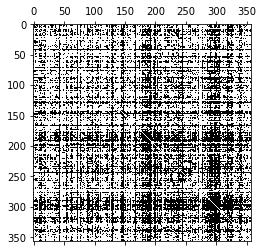

In [26]:
#Visualize and save
plt.spy(Adj_mat_1)
print(np.max(Adj_mat_1))
np.save('../data/Adjacency_Matrix_1.npy',Adj_mat_1)

### Adjacency Matrix No. 2
Same as adjacency matrix #1 but using only the first word of each ingredient

In [27]:
Adj_mat_2 = np.zeros([len(all_ingredients_unique),len(all_ingredients_unique)])
ingredients_df = df['ingredients']
for recipe in ingredients_df.values:
    ingredients = []
    for ingredient in recipe:
        ingredients += [ingredient['text'].split(',')[0]]
    indices = np.where(np.in1d(all_ingredients_unique,ingredients))
    combos = list(itertools.combinations(indices[0],2))
    for combo in combos:
        Adj_mat_2[combo[0],combo[1]] += 1
        Adj_mat_2[combo[1],combo[0]] += 1

10666.0


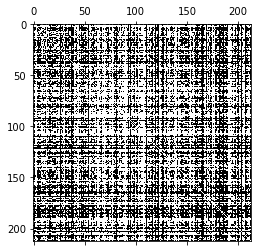

In [29]:
plt.spy(Adj_mat_2)
print(np.max(Adj_mat_2))
np.save('../data/Adjacency_Matrix_2.npy',Adj_mat_2)

### Adjacency Matrix No. 3
Build an adjacency matrix Cora-style (like we did in the first assignment): Have each recipe represent a "feature" for each ingredient. The feature equals 1 if the recipe includes that ingredient and 0 otherwise. Then use an RBF kernel to compute the distances between ingredients based on their feature vectors.

In [34]:
num_recipes = len(df)
feature = np.zeros([len(all_ingredients_full_unique),num_recipes])
ingredients_df = df['ingredients']
recipe_counter = 0
for recipe in ingredients_df.values:
    ingredients = []
    for ingredient in recipe:
        ingredients += [ingredient['text']]
    indices = np.where(np.in1d(all_ingredients_full_unique,ingredients))
    feature[indices,recipe_counter] = 1
    recipe_counter = recipe_counter + 1

32.63865095634238


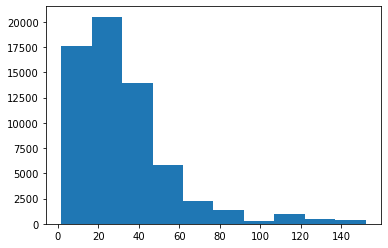

In [35]:
#Plot distances between nodes
distances = pdist(feature, metric='euclidean')
plt.hist(distances)
mean_dist = np.mean(distances)
print(mean_dist)

In [42]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    dist = squareform(pdist(X))
    adjacency = np.exp(- dist ** 2 / (2 * sigma ** 2))
    adjacency[adjacency < epsilon] = 0
    np.fill_diagonal(adjacency, 0)
    return adjacency

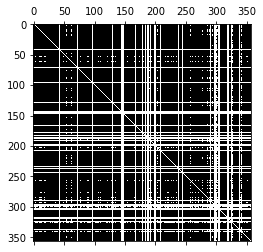

In [45]:
sigma_coeff = 0.7
sigma = sigma_coeff*mean_dist
adjacency = epsilon_similarity_graph(feature, sigma, epsilon=0.2)
plt.spy(adjacency)
plt.show()

In [48]:
#Save the matrix
np.save('../data/Adjacency_Matrix_3.npy',adjacency)

## Side note
Testing the credibility of nutrition information for each ingredient from the Recipes 1M+ database

In [49]:
length = range(len(df))
for i in length:
    rec_ingr = df.iloc[i]["ingredients"]
    for ingredient_ndx in range(len(rec_ingr)):
        if rec_ingr[ingredient_ndx]['text'] == 'broccoli, raw':
            quantity = df.iloc[i]["quantity"][ingredient_ndx]['text']
            unit = df.iloc[i]["unit"][ingredient_ndx]['text']
            nutr = df.iloc[i]["nutr_per_ingredient"][ingredient_ndx]
            print("Recipe {0}: {1} {2} of broccoli nutrition facts: {3}".format(i,quantity,unit,nutr))

Recipe 10: 1/2 cup of broccoli nutrition facts: {'fat': 0.17, 'nrg': 15.5, 'pro': 1.285, 'sat': 0.0175, 'sod': 15.0, 'sug': 0.775}
Recipe 11: 2 cup of broccoli nutrition facts: {'fat': 0.68, 'nrg': 62.0, 'pro': 5.14, 'sat': 0.07, 'sod': 60.0, 'sug': 3.1}
Recipe 14: 10 ounce of broccoli nutrition facts: {'fat': 1.0489315000000001, 'nrg': 96.38830000000002, 'pro': 7.994559, 'sat': 0.11056305, 'sod': 93.55335000000001, 'sug': 4.819415}
Recipe 67: 10 ounce of broccoli nutrition facts: {'fat': 1.0489315000000001, 'nrg': 96.38830000000002, 'pro': 7.994559, 'sat': 0.11056305, 'sod': 93.55335000000001, 'sug': 4.819415}
Recipe 187: 2 cup of broccoli nutrition facts: {'fat': 0.68, 'nrg': 62.0, 'pro': 5.14, 'sat': 0.07, 'sod': 60.0, 'sug': 3.1}
Recipe 239: 1 1/2 pound of broccoli nutrition facts: {'fat': 2.5174355999999998, 'nrg': 231.33192, 'pro': 19.186941599999997, 'sat': 0.26535131999999995, 'sod': 224.52803999999998, 'sug': 11.566595999999999}
Recipe 310: 2 cup of broccoli nutrition facts: {

Recipe 6863: 20 ounce of broccoli nutrition facts: {'fat': 2.0978630000000003, 'nrg': 192.77660000000003, 'pro': 15.989118, 'sat': 0.2211261, 'sod': 187.10670000000002, 'sug': 9.63883}
Recipe 6966: 1 1/2 cup of broccoli nutrition facts: {'fat': 0.51, 'nrg': 46.5, 'pro': 3.8549999999999995, 'sat': 0.052500000000000005, 'sod': 45.0, 'sug': 2.325}
Recipe 6982: 2 cup of broccoli nutrition facts: {'fat': 0.68, 'nrg': 62.0, 'pro': 5.14, 'sat': 0.07, 'sod': 60.0, 'sug': 3.1}
Recipe 7013: 4 cup of broccoli nutrition facts: {'fat': 1.36, 'nrg': 124.0, 'pro': 10.28, 'sat': 0.14, 'sod': 120.0, 'sug': 6.2}
Recipe 7253: 3/4 cup of broccoli nutrition facts: {'fat': 0.255, 'nrg': 23.25, 'pro': 1.9275, 'sat': 0.026250000000000006, 'sod': 22.5, 'sug': 1.1625}
Recipe 7354: 1 1/4 pound of broccoli nutrition facts: {'fat': 2.0978630000000003, 'nrg': 192.77660000000003, 'pro': 15.989118, 'sat': 0.2211261, 'sod': 187.10670000000002, 'sug': 9.63883}
Recipe 7458: 8 cup of broccoli nutrition facts: {'fat': 2.7

Recipe 14268: 1 1/2 pound of broccoli nutrition facts: {'fat': 2.5174355999999998, 'nrg': 231.33192, 'pro': 19.186941599999997, 'sat': 0.26535131999999995, 'sod': 224.52803999999998, 'sug': 11.566595999999999}
Recipe 14464: 1/2 cup of broccoli nutrition facts: {'fat': 0.17, 'nrg': 15.5, 'pro': 1.285, 'sat': 0.0175, 'sod': 15.0, 'sug': 0.775}
Recipe 14534: 14 cup of broccoli nutrition facts: {'fat': 4.760000000000001, 'nrg': 434.0, 'pro': 35.98, 'sat': 0.49000000000000005, 'sod': 420.0, 'sug': 21.7}
Recipe 14572: 14 pound of broccoli nutrition facts: {'fat': 23.496065599999998, 'nrg': 2159.09792, 'pro': 179.07812159999997, 'sat': 2.4766123199999996, 'sod': 2095.59504, 'sug': 107.954896}
Recipe 14671: 2 cup of broccoli nutrition facts: {'fat': 0.68, 'nrg': 62.0, 'pro': 5.14, 'sat': 0.07, 'sod': 60.0, 'sug': 3.1}
Recipe 14678: 1 pound of broccoli nutrition facts: {'fat': 1.6782904, 'nrg': 154.22128, 'pro': 12.7912944, 'sat': 0.17690087999999998, 'sod': 149.68536, 'sug': 7.711064}
Recipe 1

Recipe 21817: 3/4 pound of broccoli nutrition facts: {'fat': 1.2587177999999999, 'nrg': 115.66596, 'pro': 9.593470799999999, 'sat': 0.13267565999999997, 'sod': 112.26401999999999, 'sug': 5.783297999999999}
Recipe 21822: 12 ounce of broccoli nutrition facts: {'fat': 1.2587177999999999, 'nrg': 115.66596, 'pro': 9.593470799999999, 'sat': 0.13267565999999997, 'sod': 112.26401999999999, 'sug': 5.783297999999999}
Recipe 21941: 4 cup of broccoli nutrition facts: {'fat': 1.36, 'nrg': 124.0, 'pro': 10.28, 'sat': 0.14, 'sod': 120.0, 'sug': 6.2}
Recipe 21976: 2 cup of broccoli nutrition facts: {'fat': 0.68, 'nrg': 62.0, 'pro': 5.14, 'sat': 0.07, 'sod': 60.0, 'sug': 3.1}
Recipe 22068: 4 cup of broccoli nutrition facts: {'fat': 1.36, 'nrg': 124.0, 'pro': 10.28, 'sat': 0.14, 'sod': 120.0, 'sug': 6.2}
Recipe 22094: 3 cup of broccoli nutrition facts: {'fat': 1.02, 'nrg': 93.0, 'pro': 7.709999999999999, 'sat': 0.10500000000000001, 'sod': 90.0, 'sug': 4.65}
Recipe 22181: 500 g of broccoli nutrition fact

Recipe 27426: 2 cup of broccoli nutrition facts: {'fat': 0.68, 'nrg': 62.0, 'pro': 5.14, 'sat': 0.07, 'sod': 60.0, 'sug': 3.1}
Recipe 27467: 12 cup of broccoli nutrition facts: {'fat': 4.08, 'nrg': 372.0, 'pro': 30.839999999999996, 'sat': 0.42000000000000004, 'sod': 360.0, 'sug': 18.6}
Recipe 27597: 1 cup of broccoli nutrition facts: {'fat': 0.34, 'nrg': 31.0, 'pro': 2.57, 'sat': 0.035, 'sod': 30.0, 'sug': 1.55}
Recipe 27853: 1 1/2 cup of broccoli nutrition facts: {'fat': 0.51, 'nrg': 46.5, 'pro': 3.8549999999999995, 'sat': 0.052500000000000005, 'sod': 45.0, 'sug': 2.325}
Recipe 27958: 1 1/2 pound of broccoli nutrition facts: {'fat': 2.5174355999999998, 'nrg': 231.33192, 'pro': 19.186941599999997, 'sat': 0.26535131999999995, 'sod': 224.52803999999998, 'sug': 11.566595999999999}
Recipe 28238: 4 cup of broccoli nutrition facts: {'fat': 1.36, 'nrg': 124.0, 'pro': 10.28, 'sat': 0.14, 'sod': 120.0, 'sug': 6.2}
Recipe 28557: 4 cup of broccoli nutrition facts: {'fat': 1.36, 'nrg': 124.0, 'pro

Recipe 33092: 2 cup of broccoli nutrition facts: {'fat': 0.68, 'nrg': 62.0, 'pro': 5.14, 'sat': 0.07, 'sod': 60.0, 'sug': 3.1}
Recipe 33262: 2 pound of broccoli nutrition facts: {'fat': 3.3565808, 'nrg': 308.44256, 'pro': 25.5825888, 'sat': 0.35380175999999997, 'sod': 299.37072, 'sug': 15.422128}
Recipe 33296: 4 cup of broccoli nutrition facts: {'fat': 1.36, 'nrg': 124.0, 'pro': 10.28, 'sat': 0.14, 'sod': 120.0, 'sug': 6.2}
Recipe 33509: 2 cup of broccoli nutrition facts: {'fat': 0.68, 'nrg': 62.0, 'pro': 5.14, 'sat': 0.07, 'sod': 60.0, 'sug': 3.1}
Recipe 33558: 4 cup of broccoli nutrition facts: {'fat': 1.36, 'nrg': 124.0, 'pro': 10.28, 'sat': 0.14, 'sod': 120.0, 'sug': 6.2}
Recipe 33635: 2 pound of broccoli nutrition facts: {'fat': 3.3565808, 'nrg': 308.44256, 'pro': 25.5825888, 'sat': 0.35380175999999997, 'sod': 299.37072, 'sug': 15.422128}
Recipe 34001: 2 pound of broccoli nutrition facts: {'fat': 3.3565808, 'nrg': 308.44256, 'pro': 25.5825888, 'sat': 0.35380175999999997, 'sod': 29

Recipe 39557: 3 cup of broccoli nutrition facts: {'fat': 1.02, 'nrg': 93.0, 'pro': 7.709999999999999, 'sat': 0.10500000000000001, 'sod': 90.0, 'sug': 4.65}
Recipe 39728: 3 cup of broccoli nutrition facts: {'fat': 1.02, 'nrg': 93.0, 'pro': 7.709999999999999, 'sat': 0.10500000000000001, 'sod': 90.0, 'sug': 4.65}
Recipe 39752: 1 1/4 cup of broccoli nutrition facts: {'fat': 0.42500000000000004, 'nrg': 38.75, 'pro': 3.2125, 'sat': 0.043750000000000004, 'sod': 37.5, 'sug': 1.9375}
Recipe 39824: 1 1/4 pound of broccoli nutrition facts: {'fat': 2.0978630000000003, 'nrg': 192.77660000000003, 'pro': 15.989118, 'sat': 0.2211261, 'sod': 187.10670000000002, 'sug': 9.63883}
Recipe 40008: 1 cup of broccoli nutrition facts: {'fat': 0.34, 'nrg': 31.0, 'pro': 2.57, 'sat': 0.035, 'sod': 30.0, 'sug': 1.55}
Recipe 40046: 2 1/2 pound of broccoli nutrition facts: {'fat': 4.1957260000000005, 'nrg': 385.55320000000006, 'pro': 31.978236, 'sat': 0.4422522, 'sod': 374.21340000000004, 'sug': 19.27766}
Recipe 40397

Recipe 45205: 5 pound of broccoli nutrition facts: {'fat': 8.391452000000001, 'nrg': 771.1064000000001, 'pro': 63.956472, 'sat': 0.8845044, 'sod': 748.4268000000001, 'sug': 38.55532}
Recipe 45273: 3 cup of broccoli nutrition facts: {'fat': 1.02, 'nrg': 93.0, 'pro': 7.709999999999999, 'sat': 0.10500000000000001, 'sod': 90.0, 'sug': 4.65}
Recipe 45360: 20 ounce of broccoli nutrition facts: {'fat': 2.0978630000000003, 'nrg': 192.77660000000003, 'pro': 15.989118, 'sat': 0.2211261, 'sod': 187.10670000000002, 'sug': 9.63883}
Recipe 45374: 2 cup of broccoli nutrition facts: {'fat': 0.68, 'nrg': 62.0, 'pro': 5.14, 'sat': 0.07, 'sod': 60.0, 'sug': 3.1}
Recipe 45829: 1 pound of broccoli nutrition facts: {'fat': 1.6782904, 'nrg': 154.22128, 'pro': 12.7912944, 'sat': 0.17690087999999998, 'sod': 149.68536, 'sug': 7.711064}
Recipe 45904: 8 ounce of broccoli nutrition facts: {'fat': 0.8391452, 'nrg': 77.11064, 'pro': 6.3956472, 'sat': 0.08845043999999999, 'sod': 74.84268, 'sug': 3.855532}
Recipe 4593

We can conclude that there is a bug in the "nutrients per ingredient" section, because this is scaled to the quantity of the ingredient but is not consistent across units. For example, 10 oz of broccoli is less than 2 cups but has 34% more fat. Furthermore, some recipes contain erroneous quantities, such as 16 pounds of broccoli. Therefore, we use the USDA Nutrition Information Database to get nutrition statistics for each ingredient.

### Adjacency Matrix No. 4
The features of each ingredient are ten commonly-found nutrients parsed from the USDA database. If the full ingredient in the Recipes 1M+ database does not exist in the USDA database, match only the first word of the ingredient. Then, use an RBF kernel to create an adjacency matrix from the nutrition information.

In [50]:
#Match first two words of unique ingredients to ingredients in USDA database
usda_ingr_names = usda["SR description"]
#save first two words
usda_ingr_first2words = []
usda_ingr_firstword = []
for ingr in usda_ingr_names:
    word_vec = ingr.split(',')
    if len(word_vec)>2:
        usda_ingr_first2words.append(word_vec[0].lower() + ',' + word_vec[1])
    else:
        usda_ingr_first2words.append(ingr.lower())
    if len(word_vec)>1:
        usda_ingr_firstword.append(word_vec[0].lower())
    else:
        usda_ingr_firstword.append(ingr.lower())
usda_ingr_first2words_unique = np.unique(usda_ingr_first2words)
usda_ingr_firstword_unique = np.unique(usda_ingr_firstword)
print(len(usda_ingr_first2words))
print(len(usda_ingr_firstword))
print(len(usda_ingr_first2words_unique))
print(len(usda_ingr_firstword_unique))

177450
177450
1534
527


In [51]:
ingredients_matched = []; #List of all ingredients that are found in both the USDA and Recipes 1M+ datasets
ingredients_matched_mask = [];
count = 0;
for ingr in all_ingredients_full_unique:
    vec = ingr.split(',')
    if len(vec) > 2:
        ingr_name = vec[0] + ',' + vec[1]
    else:
        ingr_name = ingr
    if ingr_name in usda_ingr_first2words_unique:
        ingredients_matched.append(ingr)
        ingredients_matched_mask.append(True)
    else: #match only first word
        if vec[0] in usda_ingr_firstword_unique:
            ingredients_matched.append(ingr)
            ingredients_matched_mask.append(True)
        else:
            ingredients_matched_mask.append(False)

In [52]:
def getIngredientNutritionInfo(ingredient,stringType):
    if stringType == "firstWord":
        vecToUse = usda_ingr_firstword
    else:
        vecToUse = usda_ingr_first2words
    nutr_info = np.zeros([1,10])
    index_of_ingr = vecToUse.index(ingredient)
    fragment = usda.iloc[index_of_ingr:index_of_ingr+40]
    descriptions = fragment["Nutrient description"].values
    values = fragment["Nutrient value"].values
    for d in range(len(descriptions)):
        desc = descriptions[d]
        if (desc == "Protein"):
            nutr_info[:,0] = values[d]
        elif (desc == "Total Fat"):
            nutr_info[:,1] = values[d]
        elif desc == "Carbohydrate":
            nutr_info[:,2] = values[d]
        elif desc == "Energy":
            nutr_info[:,3] = values[d]
        elif desc == "Calcium":
            nutr_info[:,4] = values[d]
        elif desc == "Iron":
            nutr_info[:,5] = values[d]
        elif desc == "Sugars, total":
            nutr_info[:,6] = values[d]
        elif desc == "Sodium":
            nutr_info[:,7] = values[d]
        elif desc == "Vitamin B-12":
            nutr_info[:,8] = values[d]
        elif desc == "Fiber, total dietary":
            nutr_info[:,9] = values[d]
    return nutr_info

In [53]:
ingredient_nutrition_facts = np.zeros([len(ingredients_matched),10])
for i in range(len(ingredients_matched)):
    ingr = ingredients_matched[i]
    vec = ingr.split(',')
    if len(vec) > 2:
        ingr_name = vec[0] + ',' + vec[1]
    else:
        ingr_name = ingr
    if ingr_name in usda_ingr_first2words_unique:
        nutr = getIngredientNutritionInfo(ingr_name,"firstTwoWords")
        ingredient_nutrition_facts[i,:] = nutr
    else: #match only first word
        ingr_name = vec[0]
        if ingr_name in usda_ingr_firstword_unique:
            nutr = getIngredientNutritionInfo(ingr_name,"firstWord")
            ingredient_nutrition_facts[i,:] = nutr

557.630089343887


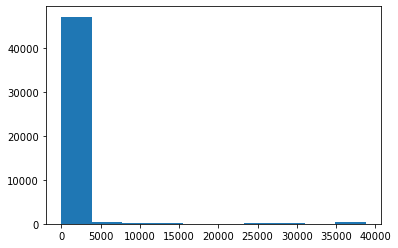

In [54]:
distances = pdist(ingredient_nutrition_facts, metric='euclidean')
plt.hist(distances)
mean_dist = np.median(distances)
print(mean_dist)

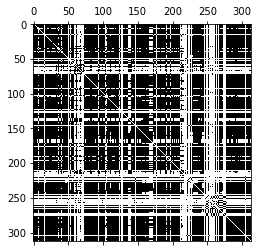

In [57]:
sigma_coeff = 0.8
sigma = sigma_coeff*mean_dist
adjacency = epsilon_similarity_graph(ingredient_nutrition_facts, sigma, epsilon=0.2)
plt.spy(adjacency)
plt.show()

(array([36607.,     0.,     0.,     0.,  2354.,  2694.,  2780.,  2208.,
         2086.,  2996.,  2576.,  2152.,  1960.,  2520.,  3672.,  3996.,
         3928.,  5166.,  5888., 14386.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

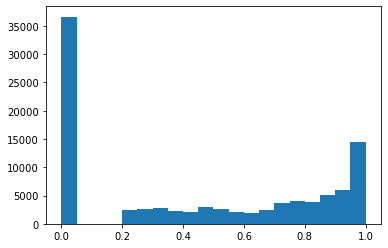

In [58]:
plt.hist(np.ravel(adjacency),bins=20)

In [60]:
np.save('../data/Ingredient_List_USDA_Nutrition_Info.npy', ingredients_matched)
np.save('../data/Adjacency_Matrix_4.npy', adjacency)

### Adjacency Matrix No. 5
Normalize the nutrition facts to the mean nutrition fact so that some nutrients are not weighted more than others

6.096383664290723


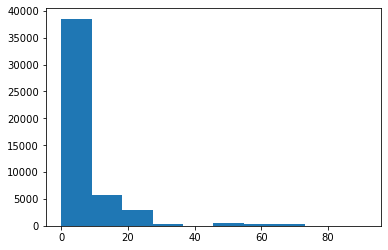

In [61]:
ingredient_nutrition_facts_normalized = ingredient_nutrition_facts / np.mean(ingredient_nutrition_facts, axis=0)
distances = pdist(ingredient_nutrition_facts_normalized, metric='euclidean')
plt.hist(distances)
mean_dist = np.median(distances)
print(mean_dist)

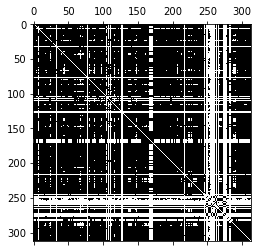

In [62]:
sigma_coeff = 0.8
sigma = sigma_coeff*mean_dist
adjacency = epsilon_similarity_graph(ingredient_nutrition_facts_normalized, sigma, epsilon=0.2)
plt.spy(adjacency)
plt.show()

In [64]:
np.save('../data/Adjacency_Matrix_5.npy', adjacency)

### Adjacency Matrix No. 6
Same as #5 but sparsified for vizualization and community detection purposes

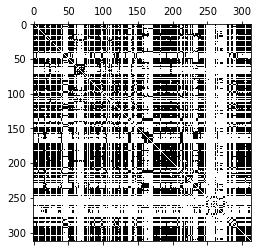

In [68]:
sigma_coeff = 0.4
sigma = sigma_coeff*mean_dist
adjacency = epsilon_similarity_graph(ingredient_nutrition_facts_normalized, sigma, epsilon=0.1)
plt.spy(adjacency)
plt.show()

(array([57503.,     0.,  3950.,  3142.,  3262.,  2466.,  2500.,  2216.,
         1414.,  1138.,  1068.,   984.,  1406.,  1560.,  1196.,  1754.,
         2150.,  2618.,  3338.,  4304.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

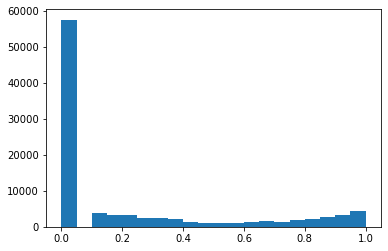

In [69]:
plt.hist(np.ravel(adjacency),bins=20)

In [70]:
np.save('../data/Adjacency_Matrix_6.npy', adjacency)

In [72]:
#Save nutrition facts matrix and nutrient labels for future reference
np.save('../data/Nutrition_Facts_Per_Ingredient.npy', ingredient_nutrition_facts)
nutrition_fact_column_labels = ["Protein", "Total Fat","Carbohydrate","Energy","Calcium","Iron","Sugars, total","Sodium","Vitamin B-12","Fiber, total dietary"]
np.save('../data/Nutrition_Facts_Column_Labels.npy', nutrition_fact_column_labels)

## Find vegan ingredients
Vitamin B-12 is only found in animal products. Therefore, we find all vegan ingredients by thresholding the ingredient list by their B-12 quantity.

In [76]:
vegan_ingredient_mask = ingredient_nutrition_facts[:,8]  < 0.05
vegan_ingredients = np.array(ingredients_matched)[vegan_ingredient_mask]
problems = ['animal fat, bacon grease', 'fat, goose', 'lard', 'soup, chicken broth or bouillon, dry', 'soup, cream of chicken, canned, condensed','soup, swanson chicken broth 99% fat free','margarine-like, margarine-butter blend, soybean oil and butter']
indices = []
for problem in problems:
    index = vegan_ingredients.tolist().index(problem)
    indices.append(index)
vegan_ingredients = np.delete(vegan_ingredients,indices)
vegan_ingredient_mask[indices] = False
print('Some vegan ingredients:')
print(vegan_ingredients[20:25])

Some vegan ingredients:
['beans, kidney, all types, mature seeds, raw' 'beans, snap, green, raw'
 'beets, raw' 'beverages, carbonated, cola, regular'
 'beverages, carbonated, ginger ale']


In [77]:
np.save('../data/Vegan_Ingredient_Mask_USDA_Nutrition_Info.npy', vegan_ingredient_mask)

### Adjacency Matrix No. 7
Concatenate recipe fetures and nutrition featues and then apply an RBF kernel. Normalize to the feature mean.
Potential problem: There are more recipe features than nutrition features, so these may be weighted more heavily

In [78]:
print(ingredient_nutrition_facts.shape)
feature_matched = feature[ingredients_matched_mask]
print(feature_matched.shape)

(313, 10)
(313, 51235)


In [79]:
#Try concatenating both
combined_feature_matrix = np.zeros([ingredient_nutrition_facts.shape[0], ingredient_nutrition_facts.shape[1] + feature_matched.shape[1]])
combined_feature_matrix[:,0:(ingredient_nutrition_facts.shape[1])] = ingredient_nutrition_facts
combined_feature_matrix[:,ingredient_nutrition_facts.shape[1]:(ingredient_nutrition_facts.shape[1]+ feature_matched.shape[1])] = feature_matched

In [80]:
#Normalize features based on mean value
#Possible problem: there are many more recipe features than nutrition ones
feature_means = np.mean(combined_feature_matrix,axis=0)
combined_feature_matrix = combined_feature_matrix[:, feature_means != 0]
feature_means = feature_means[feature_means != 0]
combined_feature_matrix_normalized = combined_feature_matrix / feature_means;
print(combined_feature_matrix_normalized.shape)

(313, 51177)


1829.2480483951592


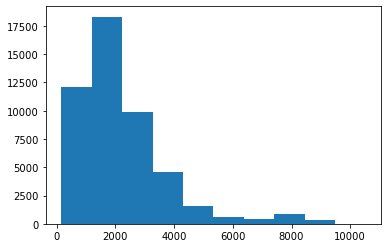

In [82]:
distances = pdist(combined_feature_matrix_normalized, metric='euclidean')
plt.hist(distances)
mean_dist = np.median(distances)
print(mean_dist)

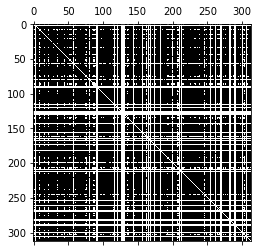

In [83]:
sigma_coeff = 0.8
sigma = sigma_coeff*mean_dist
adjacency = epsilon_similarity_graph(combined_feature_matrix_normalized, sigma, epsilon=0.2)
plt.spy(adjacency)
plt.show()

In [84]:
np.save('../data/Adjacency_Matrix_7.npy', adjacency)

### Adjacency Matrix 8
Same as 7 but without feature normalization (to try to weigh nutrition information more than recipe features)

558.9922892776581


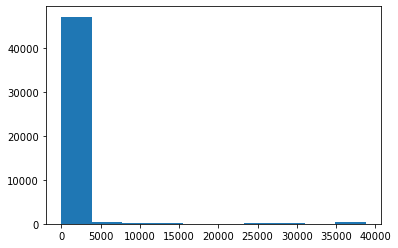

In [85]:
distances = pdist(combined_feature_matrix, metric='euclidean')
plt.hist(distances)
mean_dist = np.median(distances)
print(mean_dist)

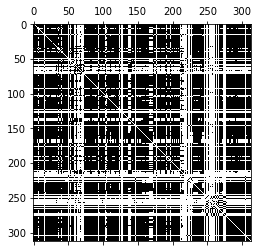

In [86]:
sigma_coeff = 0.8
sigma = sigma_coeff*mean_dist
adjacency = epsilon_similarity_graph(combined_feature_matrix, sigma, epsilon=0.2)
plt.spy(adjacency)
plt.show()

In [0]:
laplacian = compute_laplacian(adjacency,True)
lamb_norm, U_norm = spectral_decomposition(laplacian)
compute_number_connected_components(lamb_norm,threshold=1e-12)

6

In [87]:
np.save('../data/Adjacency_Matrix_8.npy', adjacency)

### Adjacency Matrix 9:
Try to combine the ingredient coocurrence adjacency matrix (#1) with the nutrition adjacency matrix (#5) by adding them. Make sure that the coocurrence weights are not weighted more heavily than the nutrition weights by dividing the cooccurrence matrix by its maximum value.

In [112]:
distances = pdist(ingredient_nutrition_facts_normalized, metric='euclidean')
mean_dist = np.median(distances)
sigma_coeff = 0.8
sigma = sigma_coeff*mean_dist
adjacency = epsilon_similarity_graph(ingredient_nutrition_facts_normalized, sigma, epsilon=0.2)

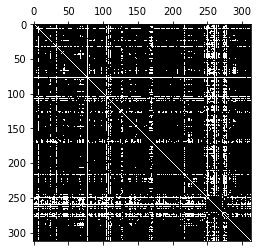

In [113]:
normalized_recipe_adj_mat = Adj_mat_1/np.max(Adj_mat_1)
normalized_recipe_adj_mat = normalized_recipe_adj_mat[ingredients_matched_mask,:]
normalized_recipe_adj_mat = normalized_recipe_adj_mat[:,ingredients_matched_mask]
combined_mat = normalized_recipe_adj_mat + adjacency
plt.spy(combined_mat)
plt.show()

In [114]:
np.save('../data/Adjacency_Matrix_9.npy', combined_mat)

### Adjacency Matrix 10: 
Same as 9 but divide the recipes matrix by its mean value instead of the max to increase its weight

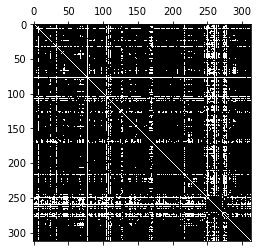

In [115]:
normalized_recipe_adj_mat = Adj_mat_1/np.mean(Adj_mat_1)
normalized_recipe_adj_mat = normalized_recipe_adj_mat[ingredients_matched_mask,:]
normalized_recipe_adj_mat = normalized_recipe_adj_mat[:,ingredients_matched_mask]
combined_mat = normalized_recipe_adj_mat + adjacency
plt.spy(combined_mat)
plt.show()

In [116]:
np.save('../data/Adjacency_Matrix_10.npy', combined_mat)

### Adjacency Matrix 11
Combine the two matrices by multiplyting them

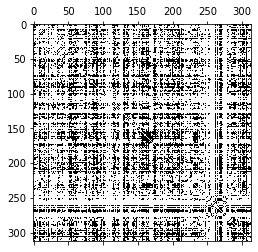

In [117]:
normalized_recipe_adj_mat = Adj_mat_1/np.max(Adj_mat_1)
normalized_recipe_adj_mat = normalized_recipe_adj_mat[ingredients_matched_mask,:]
normalized_recipe_adj_mat = normalized_recipe_adj_mat[:,ingredients_matched_mask]
combined_mat = np.multiply(normalized_recipe_adj_mat, adjacency)
plt.spy(combined_mat)
plt.show()

In [118]:
np.save('../data/Adjacency_Matrix_11.npy', combined_mat)